# View predictions 
This notebook views the predictions of the whole region for the period Dec 2020.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import torch
import xarray as xr
import pandas as pd
import os

import cartopy
import cartopy.crs as ccrs
from pyresample import load_area, geometry

import quantnn

In [2]:
f = open('../path_to_data.txt', "r") # File specifying location of data storage
path_to_dataset = os.path.join(f.readline().rstrip("\n"))
f.close() 

In [3]:
data = xr.load_dataset(os.path.join(path_to_dataset,'rain_gauge_preds','2/2020120208.nc'))

In [4]:
data

<xarray.Dataset>
Dimensions:                  (x: 1024, y: 1024)
Dimensions without coordinates: x, y
Data variables:
    xception_posterior_mean  (y, x) float32 0.01012 0.01493 ... 0.0005524
    xception_Q0.95           (y, x) float32 0.06353 0.0941 ... 0.0009571
    xception_Q0.99           (y, x) float32 0.1977 0.2948 ... 0.0009933
    mlp_posterior_mean       (y, x) float32 0.1858 0.2316 ... 0.0005516
    mlp_Q0.95                (y, x) float32 0.9656 1.192 ... 0.0009579 0.0009579
    mlp_Q0.99                (y, x) float32 3.221 3.658 ... 0.0009932 0.0009932
Attributes:
    ind_extent:   [1344 2217 2368 1193]
    area_extent:  [  -46092.39762437 -3452921.78725195  4058135.00823285   65...
    shape:        [1024 1024]
    start:        2020-12-02 07:00:00
    end:          2020-12-02 08:00:00
    datetimes:    ['[datetime.datetime(2020, 12, 2, 7, 0, 13), datetime.datet...

In [5]:
np.sum(data.mlp_posterior_mean.values<0.0)

0

In [6]:
np.isnan(data.xception_posterior_mean.values).any()

False

In [7]:
np.max(data.xception_posterior_mean.values)

41.81083

In [8]:
np.max(data.mlp_posterior_mean.values)

19.293823

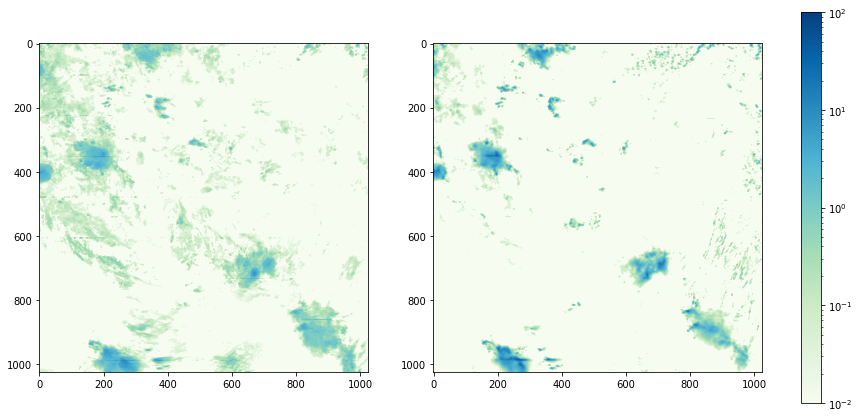

In [9]:
precip_norm = LogNorm(1e-2, 1e2)
fig, ax = plt.subplots(1, 2, figsize=(14,8))
m = ax[0].imshow(data.mlp_posterior_mean, norm=precip_norm, cmap=plt.get_cmap('GnBu'))
b = ax[1].imshow(data.xception_posterior_mean, norm=precip_norm, cmap=plt.get_cmap('GnBu'))
fig.colorbar(b, ax=ax, fraction=0.025)

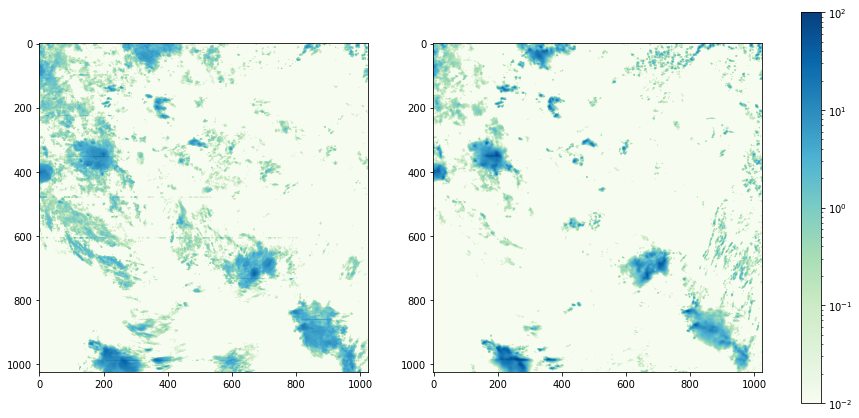

In [10]:
fig, ax = plt.subplots(1,2, figsize=(14,8))
m = ax[0].imshow(data['mlp_Q0.95'], norm=precip_norm, cmap=plt.get_cmap('GnBu'))
b = ax[1].imshow(data['xception_Q0.95'], norm=precip_norm, cmap=plt.get_cmap('GnBu'))
fig.colorbar(b, ax=ax, fraction=0.025)

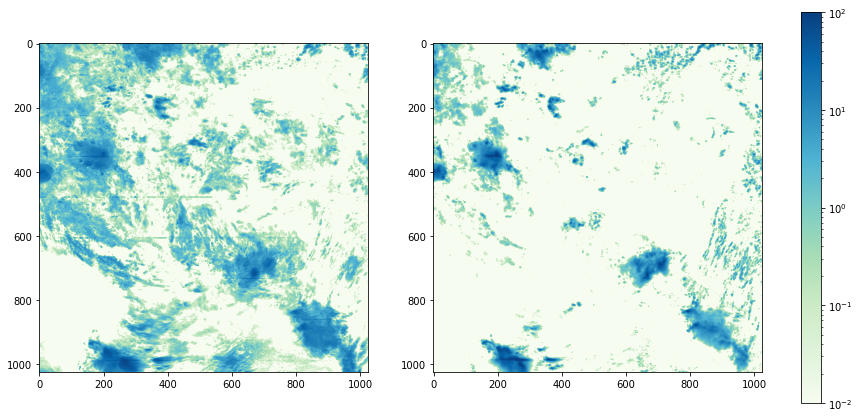

In [11]:
fig, ax = plt.subplots(1,2, figsize=(14,8))
m = ax[0].imshow(data['mlp_Q0.99'], norm=precip_norm, cmap=plt.get_cmap('GnBu'))
b = ax[1].imshow(data['xception_Q0.99'], norm=precip_norm, cmap=plt.get_cmap('GnBu'))
fig.colorbar(b, ax=ax, fraction=0.025)

In [12]:
path_to_rain_gauge_data = '../reference/'
region_ind_extent = data.ind_extent
area_path='../dataset/downloads/files/areas.yaml'
area_def = load_area(area_path, 'full_disk')
metadata = pd.read_pickle(os.path.join(path_to_dataset, 'real_rain_gauge_data', 'general_rain_gauge_info.pckl'))
gauge_locs = metadata[['col', 'row']]

/export/home/ingrid/anaconda3/envs/geo/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


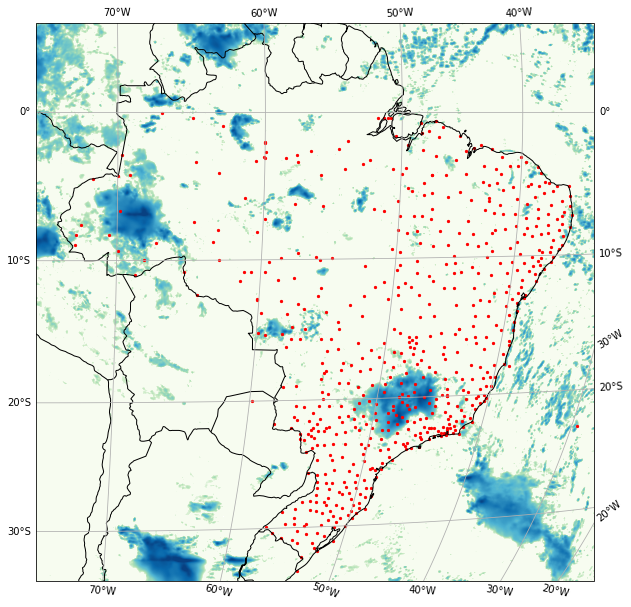

In [14]:
projcoords_x, projcoords_y = area_def.get_proj_vectors()
projcoords_mat_x, projcoords_mat_y = area_def.get_proj_coords()

area_def_ext_region = area_def.copy(area_extent = data.area_extent,
                                                  height = data.shape[0], 
                                                  width = data.shape[1])
crs = area_def_ext_region.to_cartopy_crs()
fig, ax = plt.subplots(subplot_kw={'projection': crs}, figsize = (10,11))
ax.scatter(x=projcoords_mat_x[gauge_locs.row, gauge_locs.col], 
           y=projcoords_mat_y[gauge_locs.row, gauge_locs.col], transform=crs, s=5, color='red')
ax.imshow(data['xception_Q0.99'], extent=crs.bounds, origin='upper', norm=precip_norm, transform=crs, cmap=plt.get_cmap('GnBu'))
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.add_feature(cartopy.feature.BORDERS)
ax.set_global()
#ax.title.set_text(plot_title)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()